In [ ]:
import sys
sys.path.append('..')

import os
project_root = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))

INITIAL_BALANCE = 1000.0
WINDOW_SIZE = 10
COMMISSION = 0.0001
SLIPPAGE = 0.0005
MAX_HOLDING_TIME = 60 * 24
HOLDING_THRESHOLD = 24
MAX_DRAWDOWN_THRESHOLD = 0.05
LAMBDA_DRAWDOWN = 0.1 
LAMBDA_HOLD = 0.025 
REWARD_SCALING=100.0 


import pandas as pd

TRAIN_VERSION="v3"

data_path = "../data/data_1h_2023.csv"
df1 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")
data_path = "../data/data_1h_2024.csv"
df2 = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")
train_data = pd.concat([df1, df2])

data_path = "../data/data_1h_2025.csv"
test_data = pd.read_csv(data_path, index_col=0, parse_dates=True, date_format="iso8601")

df_full = train_data.copy()


СРАВНЕНИЕ АГЕНТОВ (улучшенная версия)


Q-Learning
------------------------------------------------------------
Доходность: -50.07%
Сделок: 958
Макс. просадка портфеля: 58.15%

SARSA
------------------------------------------------------------
Доходность: -4.49%
Сделок: 21
Макс. просадка портфеля: 7.27%

SARSA-λ
------------------------------------------------------------
Доходность: +42.83%
Сделок: 438
Макс. просадка портфеля: 27.86%

Monte Carlo
------------------------------------------------------------
Доходность: +399.58%
Сделок: 23
Макс. просадка портфеля: 38.33%


ИТОГИ


Лучшие по доходности:


,Агент,Доходность %,Конечный баланс,Max Drawdown портфеля %
3,Monte Carlo,399.582717,4995.827174,38.334004
2,SARSA-λ,42.827717,1428.277174,27.863390
1,SARSA,-4.494860,955.051399,7.267210
0,Q-Learning,-50.066963,499.330366,58.148439



Лучшие по минимальной просадке:


,Агент,Max Drawdown портфеля %,Доходность %
1,SARSA,7.267210,-4.494860
2,SARSA-λ,27.863390,42.827717
3,Monte Carlo,38.334004,399.582717
0,Q-Learning,58.148439,-50.066963



Лучшие по Sharpe Ratio:


,Агент,Sharpe Ratio,Доходность %,Max Drawdown портфеля %
3,Monte Carlo,0.328794,399.582717,38.334004
2,SARSA-λ,0.142373,42.827717,27.863390
1,SARSA,-0.100309,-4.494860,7.267210
0,Q-Learning,-0.252053,-50.066963,58.148439



Полная таблица:


,Агент,Доходность %,Конечный баланс,Сделок,Win Rate %,Средний PnL,Max Drawdown сделок %,Max Drawdown портфеля %,Sharpe Ratio,Ср. время удержания,Закрыто по просадке,Закрыто по времени
0,Q-Learning,-50.066963,499.330366,958,43.319415,-0.437975,6.538307,58.148439,-0.252053,2.346555,0,0
1,SARSA,-4.494860,955.051399,21,52.380952,-2.040544,3.224902,7.267210,-0.100309,1.428571,0,0
2,SARSA-λ,42.827717,1428.277174,438,30.136986,1.123658,3.421135,27.863390,0.142373,6.525114,0,0
3,Monte Carlo,399.582717,4995.827174,23,39.130435,173.036747,6.400294,38.334004,0.328794,736.652174,14,9



Результаты сохранены в consistent_comparison_results.csv

Строим графики роста портфеля...


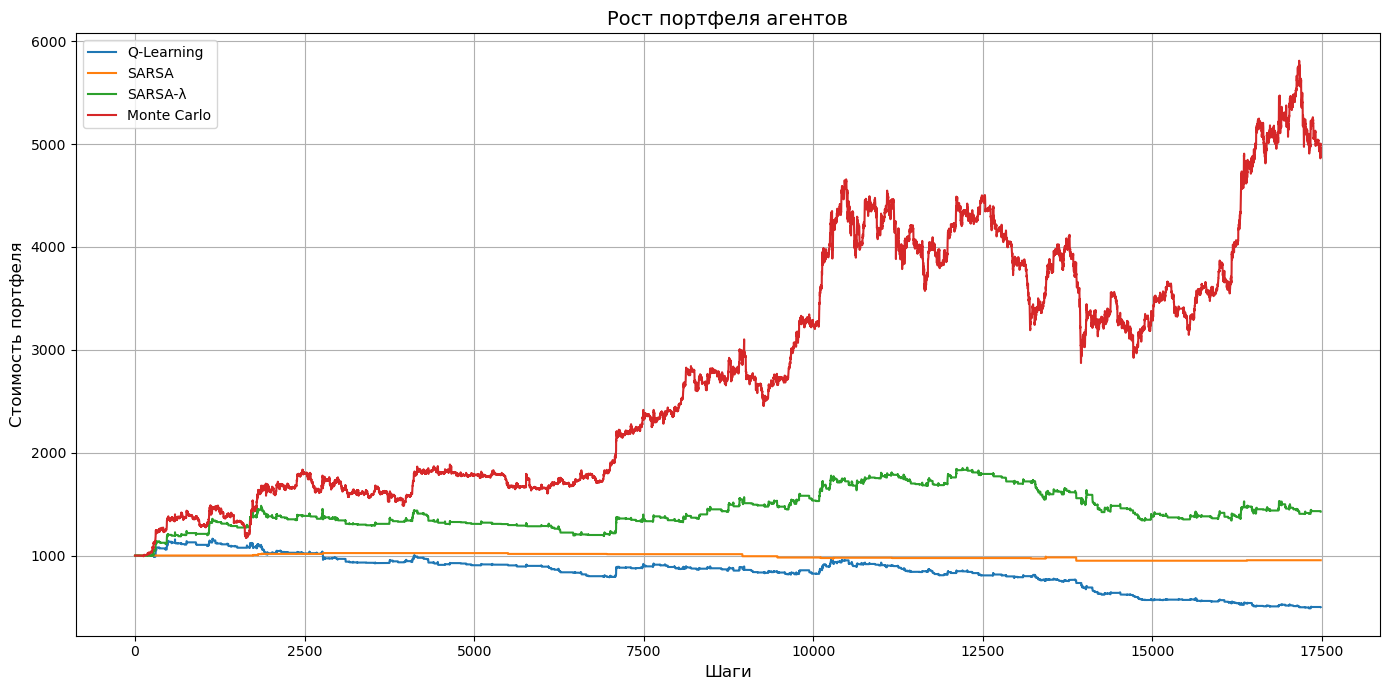

График сохранён: portfolio_growth.png


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

import sys

sys.path.append("..")
from envs.trading_env import MyTradingEnv


class ConsistentAgentComparator:
    def discretize_state(self, observation):
        return tuple(map(int, observation))

    def run(self):
        print("\n" + "=" * 80)
        print("СРАВНЕНИЕ АГЕНТОВ (улучшенная версия)")
        print("=" * 80 + "\n")

        agents = {
            "Q-Learning": f"../training_data/checkpoints/exp_qlearn_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA": f"../training_data/checkpoints/exp_sarsa_{TRAIN_VERSION}/final_agent.pkl",
            "SARSA-λ": f"../training_data/checkpoints/exp_sarsa_lambda_{TRAIN_VERSION}/final_agent.pkl",
            "Monte Carlo": f"../training_data/checkpoints/exp_monte_carlo_{TRAIN_VERSION}/final_agent.pkl",
        }

        df = df_full.copy()
        results = []
        portfolio_history = {}

        for name, path in agents.items():
            print(f"\n{name}")
            print("-" * 60)

            if not Path(path).exists():
                print(f"Файл не найден: {path}")
                continue

            try:
                with open(path, "rb") as f:
                    agent_data = pickle.load(f)

                class TestAgent:
                    def __init__(self, data, discretize_func):
                        self.q_table = data.get("q_table", {})
                        self.discretize = discretize_func

                    def select_action(self, state, greedy=True):
                        state_key = self.discretize(state)
                        q_vals = self.q_table.get(state_key, None)
                        if isinstance(q_vals, (list, np.ndarray)) and len(q_vals) == 3:
                            return int(np.argmax(q_vals))
                        return 1

                agent = TestAgent(agent_data, self.discretize_state)

                env = MyTradingEnv(
                    df=df.copy(),
                    initial_balance=INITIAL_BALANCE,
                    window_size=WINDOW_SIZE,
                    commission=COMMISSION,
                    slippage=SLIPPAGE,
                    max_holding_time=MAX_HOLDING_TIME,
                    lambda_drawdown=LAMBDA_DRAWDOWN,
                    lambda_hold=LAMBDA_HOLD,
                    reward_scaling=REWARD_SCALING,
                )

                state, info = env.reset()
                done = False

                while not done:
                    action = agent.select_action(state, greedy=True)
                    state, reward, done, truncated, info = env.step(action)

                metrics = env.get_metrics()

                env.reset()
                portfolio_values = []
                state, info = env.reset()
                done = False

                while not done:
                    action = agent.select_action(state, greedy=True)
                    next_state, reward, done, truncated, info = env.step(action)
                    portfolio_values.append(info["portfolio_value"])
                    state = next_state

                portfolio_values = np.array(portfolio_values)

                peak = np.maximum.accumulate(portfolio_values)
                drawdowns = (peak - portfolio_values) / peak
                max_portfolio_drawdown = np.max(drawdowns) if len(drawdowns) else 0

                returns = np.diff(portfolio_values) / portfolio_values[:-1]
                sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)

                portfolio_history[name] = portfolio_values

                results.append(
                    {
                        "Агент": name,
                        "Доходность %": (env._portfolio_value / 1000 - 1) * 100,
                        "Конечный баланс": env._portfolio_value,
                        "Сделок": metrics.get("total_trades", 0),
                        "Win Rate %": metrics.get("win_rate", 0),
                        "Средний PnL": metrics.get("avg_pnl", 0),
                        "Max Drawdown сделок %": metrics.get("max_drawdown", 0) * 100,
                        "Max Drawdown портфеля %": max_portfolio_drawdown * 100,
                        "Sharpe Ratio": sharpe,
                        "Ср. время удержания": metrics.get("avg_holding_time", 0),
                        "Закрыто по просадке": metrics.get(
                            "trades_closed_by_drawdown", 0
                        ),
                        "Закрыто по времени": metrics.get("trades_closed_by_time", 0),
                    }
                )

                print(f"Доходность: {(env._portfolio_value / 1000 - 1) * 100:+.2f}%")
                print(f"Сделок: {metrics.get('total_trades', 0)}")
                print(f"Макс. просадка портфеля: {max_portfolio_drawdown * 100:.2f}%")

            except Exception as e:
                print(f"Ошибка при обработке агента {name}: {e}")
                continue

        if not results:
            print("\nНет данных для сравнения")
            return

        print("\n\n" + "=" * 80)
        print("ИТОГИ")
        print("=" * 80 + "\n")

        df_results = pd.DataFrame(results)

        pd.set_option("display.width", 220)
        pd.set_option("display.max_columns", None)

        print("\nЛучшие по доходности:")
        display(
            df_results.sort_values("Доходность %", ascending=False)[
                ["Агент", "Доходность %", "Конечный баланс", "Max Drawdown портфеля %"]
            ]
        )

        print("\nЛучшие по минимальной просадке:")
        display(
            df_results.sort_values("Max Drawdown портфеля %")[
                ["Агент", "Max Drawdown портфеля %", "Доходность %"]
            ]
        )

        print("\nЛучшие по Sharpe Ratio:")
        display(
            df_results.sort_values("Sharpe Ratio", ascending=False)[
                ["Агент", "Sharpe Ratio", "Доходность %", "Max Drawdown портфеля %"]
            ]
        )

        print("\nПолная таблица:")
        display(df_results)

        df_results.to_csv("consistent_comparison_results.csv", index=False)
        print("\nРезультаты сохранены в consistent_comparison_results.csv")

        print("\nСтроим графики роста портфеля...")
        plt.figure(figsize=(14, 7))
        for name, values in portfolio_history.items():
            plt.plot(values, label=name)

        plt.title("Рост портфеля агентов", fontsize=14)
        plt.xlabel("Шаги", fontsize=12)
        plt.ylabel("Стоимость портфеля", fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.savefig("portfolio_growth.png")
        plt.show()
        plt.close()

        print("График сохранён: portfolio_growth.png")


if __name__ == "__main__":
    comparator = ConsistentAgentComparator()
    comparator.run()